# Project 3: Source Panel Method

In this project, the goal is to approximate fluid flow over a surface with the source panel method. This panel uses many discrete source panels along a surface in a uniform cross-flow to calculate fluid flow. Fluid is able to flow through each panel at any point besides the center so an increased amount of panel sources will create a more accurate representation of the flow around a continuous surface. First, a cylinder in cross-flow will be approximated with an increasing number of panels and then a symmetric airfoil will be also be analyzed in the same fashion.

## Problem 1: Flow Over a Non-Rotating Cylinder
The first problem consists of approximating the flow over a static cylinder using the panel method. The number of discrete panels will increase to achieve theoretically more accurate results.

Conservation of mass holds for current calculation of source strengths
Conservation of mass holds for current calculation of source strengths
Conservation of mass holds for current calculation of source strengths
Conservation of mass holds for current calculation of source strengths
Conservation of mass holds for current calculation of source strengths
Conservation of mass holds for current calculation of source strengths


<ipython-input-110-881a277cdaa5>:187: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(integrand, 0.0, panel.length)[0]
<ipython-input-110-881a277cdaa5>:187: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(integrand, 0.0, panel.length)[0]


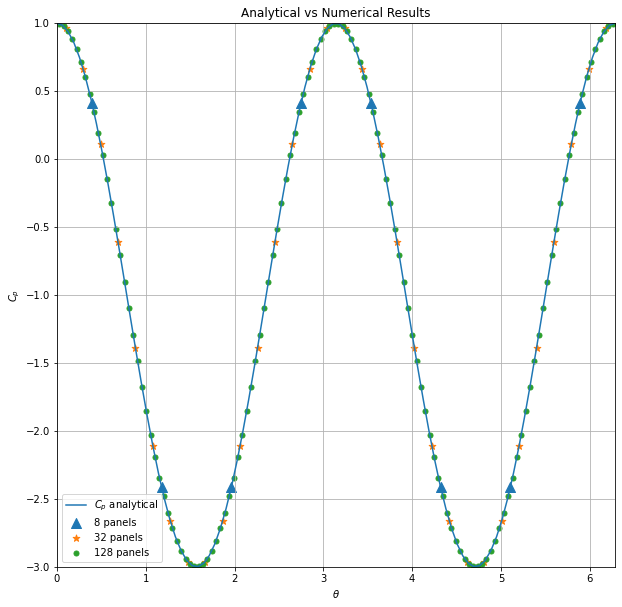

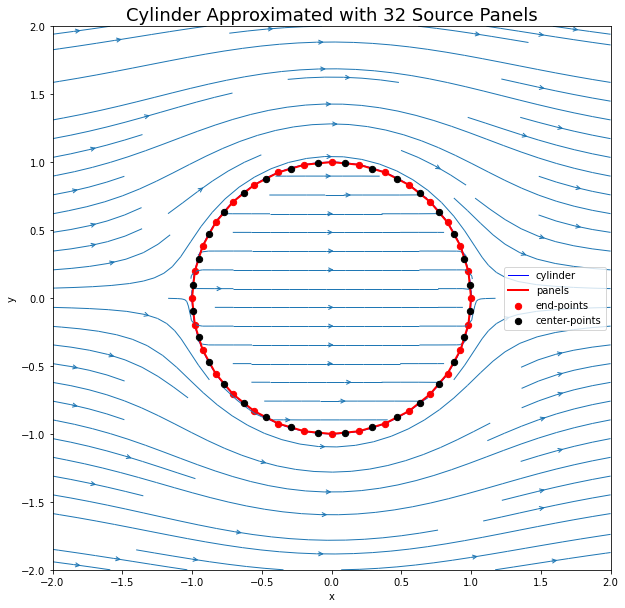

In [110]:
# First section adapted from AeroPython lesson 9
import math
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
# embed the figures into the notebook
%matplotlib inline


class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb

        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel

        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)

        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient


# Now we set up the boundary condition of no flow through panel centers and find the source strengths of each panel
def integral_normal(p_i, p_j):
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

def integral_tangential(p_i, p_j):
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

# plot the surface pressure coefficient
# plt.figure(figsize=(10, 6))
# plt.grid()
# plt.xlabel('x', fontsize=16)
# plt.ylabel('$C_p$', fontsize=16)
# plt.plot(x_cylinder, cp_analytical,
#             label='analytical',
#             color='b', linestyle='-', linewidth=1, zorder=1)
# plt.scatter([p.xc for p in panels], [p.cp for p in panels],
#                label='source-panel method',
#                color='r', s=40, zorder=2)
# plt.title('Number of panels : %d' % N_panels, fontsize=16)
# plt.legend(loc='best', prop={'size':16})
# plt.xlim(-1.0, 1.0)
# plt.ylim(-4.0, 2.0)


#1a panel method solver
def panel_method_solver(n):
    u_inf = 1.0

    # define the cylinder of unit radius centered at (0, 0)
    R = 1.0
    x_center, y_center = 0.0, 0.0
    theta = np.linspace(0.0, 2 * math.pi, 100)
    x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                            y_center + R * np.sin(theta))

    N_panels = n  # number of panels desired

    # define the end-points of the panels
    x_ends = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
    y_ends = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

    # define the panels
    panels = np.empty(N_panels, dtype=object)
    for i in range(N_panels):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

    # compute the source influence matrix
    A = np.empty((N_panels, N_panels), dtype=float)
    np.fill_diagonal(A, 0.5)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)

    # compute the RHS of the linear system
    b = - u_inf * np.cos([p.beta for p in panels])
    # solve the linear system
    sigma = np.linalg.solve(A, b)

    # find the source strength for each panel
    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]

    # compute the matrix of the linear system
    A = np.empty((N_panels, N_panels), dtype=float)
    np.fill_diagonal(A, 0.0)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

    # compute the RHS of the linear system
    b = - u_inf * np.sin([panel.beta for panel in panels])

    # compute the tangential velocity at each panel center-point
    vt = np.dot(A, sigma) + b

    for i, panel in enumerate(panels):
        panel.vt = vt[i]

    # calculate the surface pressure coefficient
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / u_inf)**2

    # calculate the analytical surface pressure coefficient
    cp_analytical = 1.0 - 4 * (y_cylinder / R)**2
    # Conservation of mass check
    total = 0
    for i, panel in enumerate(panels):
        total += panel.sigma
    if abs(total)<0.00001:
        print('Conservation of mass holds for current calculation of source strengths')
    else:
        print('CONSERVATION OF MASS DOES NOT HOLD FOR CURRENT CALCULATION OF SOURCE STRENGTHS')
    return cp_analytical, panels, x_ends, y_ends

#1b discretizing multiple times and solving
panel_nums = [8, 32, 128, 256, 384]
all_panels = [0, 0, 0, 0, 0]
for i, num in enumerate(panel_nums):
    cp_analytical, all_panels[i], _, _ = panel_method_solver(num)
#print(panels[1][1].beta)

#1c plotting the pressure distribution as a function of theta
plt.figure(figsize=(10, 10))
theta = np.linspace(0, 2*math.pi, num=100)
plt.plot(theta, cp_analytical, label='$C_p$ analytical')

styles = ['^', '*', 'o']
sizes = [100, 50, 25]
for i in range(3):
    angles = []
    cps = []
    for j in range(len(all_panels[i])):
        angles.append(all_panels[i][j].beta)
        cps.append(all_panels[i][j].cp)
    plt.scatter(angles, cps, label=f'{panel_nums[i]} panels', marker=styles[i], s=sizes[i])

plt.xlim(0, 2*math.pi)
plt.ylim(-3.0, 1.0)
plt.xlabel(r'$\theta$')
plt.ylabel('$C_p$')
plt.title('Analytical vs Numerical Results')
plt.legend()
plt.grid()

#1e plotting streamlines around cylinder with 32 panels
_, p, x_ends, y_ends = panel_method_solver(32)
n = 201 # I'm using the extra +1 to help get cleaner increments in linspace                      
x_start, x_end = -2.0, 2.0           
y_start, y_end = -2.0, 2.0
x = np.linspace(x_start, x_end, n)
y = np.linspace(y_start, y_end, n)   
X, Y = np.meshgrid(x, y)  

u_inf = 1
psi_freestream = u_inf* Y # stream function for uniform flow



def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]



# this function is for the velocity at any point in the grid due to the source which sits at (xs, ys)
def get_velocity_field(panels, u_inf, X, Y):
    # freestream contribution
    u = u_inf * np.ones_like(X, dtype=float)
    v = u_inf * np.zeros_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    return u, v

# this one is for calculating the stream function of the source at any point in the grid
def get_stream_function(strength, xs, ys, X, Y):
    psi = strength / (2 * np.pi) * np.arctan2((Y - ys), (X - xs))
    return psi

u, v = get_velocity_field(p, u_inf, X, Y)
psi_source = get_stream_function(p[0].sigma, p[0].xc, p[0].yc, X, Y)
psi_source += get_stream_function(p[i].sigma, p[i].xc, p[i].yc, X, Y)
    
# superposition of the source on the freestream
psi = psi_freestream + psi_source

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')

R = 1.0
x_center, y_center = 0.0, 0.0
theta = np.linspace(0.0, 2 * math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))
# plot the panels and cylinder

plt.plot(x_cylinder, y_cylinder, label='cylinder', color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends, label='panels', color='r', linestyle='-', linewidth=2)
plt.scatter([pan.xa for pan in p], [pan.ya for pan in p], label='end-points', color='r', s=40)
plt.scatter([pan.xc for pan in p], [pan.yc for pan in p], label='center-points', color='k', s=40, zorder=3)
#plt.legend(loc='best', prop={'size':16})
plt.title('Cylinder Approximated with 32 Source Panels', fontsize=18)
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


### Part 1d
Based on the plot of pressure coefficients with varying numbers of panels, the panel method very closely approximates the analytical solution even with few panels. The plotted points from the numerical method are relatively very close to the expected analytical results. With few panels and plotted points, there are larger gaps in the data which do not show the entire curve characteristic that is demonstrated in the analytical results. The exact error will be calculated and compared between varying panel number trials below.

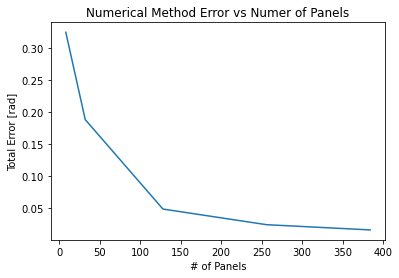

In [111]:
# 1e
error = []
for i in range(5):
    cps = []
    angles = []
    for j in range(len(all_panels[i])):
        cps.append(all_panels[i][j].cp)
        angles.append(all_panels[i][j].beta)
    numerical = np.trapz(cps, angles)
    analytical = np.trapz(cp_analytical, theta)
    error.append(analytical-numerical)
plt.plot([8, 32, 128, 256, 384], error)
plt.title('Numerical Method Error vs Numer of Panels')
plt.xlabel('# of Panels')
plt.ylabel('Total Error [rad]')
plt.show()

This graph reveals that increasing the panel number decreases the error exponentially but approaches zero quickly. Increasing the panel number increases computer workload so a set amount of acceptable error can be determined to balance the desired smaller error with the costly computer resources necessary.

## Problem 2: Symmetric Airfoil
Now the same panel method will be used to analyze the flow around a symmetric airfoil in a similar fashion to how the flow was calculated around the non-rotating cylinder. We will be using an alpha of zero for simplicity. The results of the panel method will be compared to our analytical solutions. The pressure coefficients calculated from the flow field will also be used to find the lift and drag coefficients.

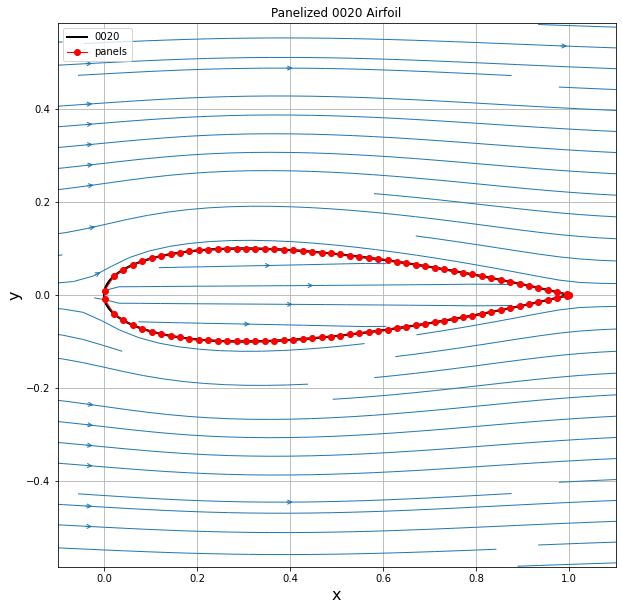

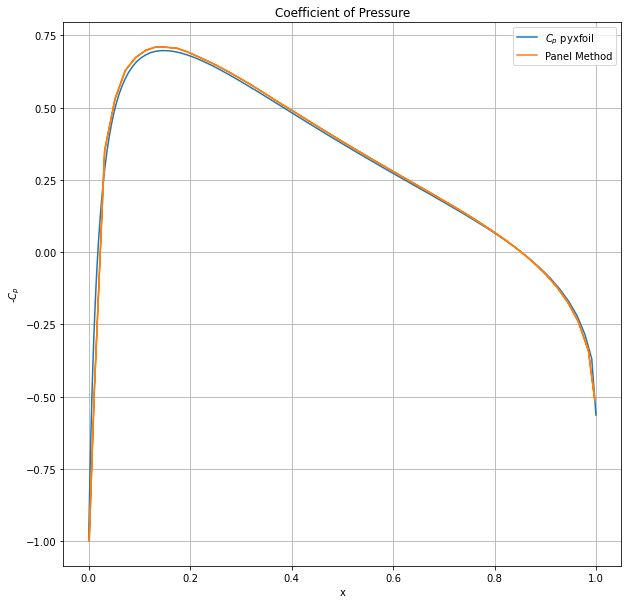

In [114]:
import os
import math
from scipy import integrate
# display the figures in the Notebook
%matplotlib inline

# read of the geometry from a data file
naca_filepath = os.path.join('resources', 'naca0020.dat')

with open(naca_filepath, 'r') as file_name:
    x, y=np.loadtxt(file_name,unpack=True)

# from aeropython lesson 10
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

# from panel discretization demo
def FindLE_top(X):
    xold = X[0]
    for i, x in enumerate(X[1:]):
        if x >= xold:
            return i #return index of Leading Edge (divides upper/lower surfs)
        else:
            xold = x
def FindLE_bot(X):
    Xreverse = X[::-1]
    xold = Xreverse[0]
    for i, x in enumerate(Xreverse[1:]):
        if x >= xold:
            return len(X) - 1 - i #return index of Leading Edge (divides upper/lower surfs)
        else:
            xold = x
def MsesSplit(x, y):
    iLE_top = FindLE_top(x)
    iLE_bot = FindLE_bot(x)
    up = y[iLE_top::-1]
    lo = y[iLE_bot:]
    return up, lo
def MsesInterp(xout, xmses, ymses):
    xup_mses, xlo_mses = MsesSplit(xmses, xmses)
    yup_mses, ylo_mses = MsesSplit(xmses, ymses)
    yup = np.interp(xout, xup_mses, yup_mses)
    ylo = np.interp(xout, xlo_mses, ylo_mses)
    return yup, ylo
def MsesMerge(xlo, xup, ylo, yup):
    if xlo[0] == xup[0] and ylo[0] == yup[0]:
        xlo = xlo[1:]
        ylo = ylo[1:]
    n1 = len(xup)     #number of upper surface points
    n = n1 + len(xlo) #number of upper AND lower surface points
    x, y = np.zeros(n), np.zeros(n)
    x[:n1], y[:n1] = xup[-1::-1], yup[-1::-1]
    x[n1:], y[n1:] = xlo, ylo
    return x, y
def ConstantSpacingAirfoil(xgeom, ygeom, n_panel, frac=0.25):
    c = max(xgeom) - min(xgeom) #chord
    if n_panel%2 != 0:
        Nsurf = (n_panel + 1) / 2
        Nsurf = int(Nsurf)
        xoffset = 1 #offset LE so we have flat LE
    else:
        Nsurf = (n_panel + 2) / 2
        Nsurf=int(Nsurf)
        xoffset = 0 #do not offset LE
    TE_length = (frac * c) / (Nsurf + (frac - 1))
    xLE = min(xgeom) + 0.001 * c * xoffset
    xTE = max(xgeom) - TE_length
    xnew = np.linspace(xLE, xTE, Nsurf-1)
    xnew = np.append(xnew, max(xgeom))
    ynewup, ynewlo = MsesInterp(xnew, xgeom, ygeom)
    if xoffset == 0:
        yLE = (ynewup[0] + ynewlo[0])/2
        ynewup[0] = yLE
        ynewlo = ynewlo[1:]
        xnewlo = xnew[1:]
    else:
        xnewlo = np.array(xnew)
    
    xends, yends = MsesMerge(xnewlo, xnew, ynewlo, ynewup)
    return xends, yends

def define_panels(x, y, N=101):
    
    x_ends, y_ends = ConstantSpacingAirfoil(x, y, N, frac=0.25)
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels
N = 101                       # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plot the panels and geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.plot(x, y, color='k', linestyle='-', linewidth=2, label='0020')
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='r', label='panels')

plt.title('Panelized 0020 Airfoil')
plt.legend()


# from aeropython lesson 10
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians
# define and create the freestream
u_inf = 1.0                            # freestream spee
alpha = 0.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)  # instantiation of the object freestream
def build_matrix(panels):
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   math.cos(p_i.beta),
                                                   math.sin(p_i.beta))
    return A
def build_rhs(panels, freestream):
    b = np.empty(len(panels), dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    return b
A = build_matrix(panels)           # compute the singularity matrix
b = build_rhs(panels, freestream)  # compute the freestream RHS
sigma = np.linalg.solve(A, b)
for i, panel in enumerate(panels):
    panel.sigma = sigma[i]


def get_tangential_velocity(panels, freestream):
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.0)    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   -math.sin(p_i.beta),
                                                   math.cos(p_i.beta))    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])    
    sigma = np.array([panel.sigma for panel in panels])  
    vt = np.dot(A, sigma) + b    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]
get_tangential_velocity(panels, freestream)
def get_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
get_pressure_coefficient(panels, freestream)
# plotting streamlines
#u, v = get_velocity_field(panels, freestream.u_inf, X, Y)
plt.streamplot(X, Y, u, v, density=3, linewidth=1, arrowsize=1, arrowstyle='->')
plt.show()

cp_filepath = os.path.join('resources', 'naca0020_surfCP_Re0.00e+00a0.0.dat')
with open(cp_filepath, 'r') as file_name:
    x, y, c = np.loadtxt(file_name,unpack=True)
# plotting the difference in cp between panel method solver and pyxfoil  
plt.figure(figsize=(10, 10))
plt.plot(x[0:int(len(x)/2)], -c[0:int(len(x)/2)], label='$C_p$ pyxfoil')
cps = []
xs = []
for i in range(len(panels)):
    cps.append(-panels[i].cp)
    xs.append(panels[i].xc)
    
plt.plot(xs, cps, label='Panel Method')
plt.ylabel('-$C_p$')
plt.xlabel('x')
plt.title('Coefficient of Pressure')
plt.legend()
plt.grid()


## Problem 3: Additional Problems
The following are extra problems used to supplement the concepts learned in lecture and to offer an opportunity to use computer-aided solving methods.

### 3.1 Irrotationality
In fluid mechanics, irrotationality describes a flow that satisfies the LaPlace equation: $\vec{\nabla} \times \vec{v} = 0$. Irrotationality means that an element of fluid on a streamline experiences differing velocities in adjacent streamlines, influencing it to rotate. An example of an irrotational flow field is the point-source potential flow.

For a point-source potential flow, the velocity components are as follows:
$\newline V_r = \frac{\lambda}{2 \pi r} $
$\newline V_\theta = 0 \newline$
where $\lambda$ is the source strength. Performing the curl on the velocity as shown in the LaPlace equation yields:
$\newline \vec{\nabla} \times \vec{v} = \frac{1}{r} \begin{vmatrix} \vec{r} & \vec{\theta} & \vec{z} \\ \frac{\partial}{\partial r} & \frac{\partial}{\partial \theta} & \frac{\partial}{\partial z} \\ \frac{\lambda}{2 \pi r} & 0 & 0 \end{vmatrix} \newline = \frac{1}{r} [- \frac{\partial}{\partial z}(\frac{\lambda}{2 \pi r})\vec{\theta} - \frac{\partial}{\partial \theta}(\frac{\lambda}{2 \pi r})\vec{z} ] \newline = \frac{1}{r} [ 0 - 0] = 0\newline$
The LaPlace equation holds and the source potential flow is irrotational.

### 3.2 Circular Cylinder
The cylindrical support stut holding up the space shuttle on top of a Boeing 747 experiences a significant amount of dynamic pressure and may result in lots of drag on the joint aircraft. The pressure at the leading edge and 45 degrees from the leading edge are estimated below. Given parameters: $\newline v = 175kn \newline D = 12in \newline Alt = 12,000ft \newline$
From standard atmosphere: $\rho$ = 1.6480 slug/ft^3 $\newline p_\infty = 1.3462 $ pounds per square foot $\newline$
175kn = 295.367 feet per sec $\newline$

Ideal coefficient of pressure distribution: $C_p = 1-4sin^2(\theta)\newline C_p = \frac{p-p_\infty }{0.5\rho v_\infty ^2}\newline  p = 2 C_p \rho v_\infty ^2 + p_\infty \newline$

At leading edge: $C_p(0) = 1-sin(0) = 1 \newline p = 2*1*1.3462*(295.367)^2 + 1.3462 = 9787.4 $ psi $\newline$

At $45\degree$ from leading edge: $C_p(45\degree) = 1-sin(45\degree) = 0.2928 \newline p = 2*0.2928*1.3462*(295.367)^2 + 1.3462 = 2129.1$ psi

These results indicate that the strut experiences stresses that should not be neglected when designing its cross section and size.


